Подключаем библиотеки

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

Загружаем данные

In [71]:
dataset = pd.read_csv('for_eda.csv')

In [72]:
dataset.shape

(100000, 12)

# Context

In [73]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


PassengerId — идентификатор пассажира

Survival — поле в котором указано спасся человек (1) или нет (0)

Pclass — содержит социально-экономический статус:
1) высокий
2) средний
3) низкий

Name — имя пассажира

Sex — пол пассажира

Age — возраст

SibSp — содержит информацию о количестве родственников 2-го порядка (муж, жена, братья, сетры)

Parch — содержит информацию о количестве родственников на борту 1-го порядка (мать, отец, дети)

Ticket — номер билета

Fare — цена билета

Cabin — каюта

Embarked — порт посадки

C — Cherbourg

Q — Queenstown

S — Southampton

# Data quality assessment

Количество элементов nan в датафрейме.

In [74]:
dataset.isna().sum()

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

Количество пропущенных значений в столбце Cabin значительно, но мы не можем заполнить их значениями основываясь на известных
данных. Хоть пропущенных значений Ticket немного, но обработать мы их так же не можем, по аналогичной ситуации с Cabin. Пропущенные значения Age мы можем обработать. Так как скорее всего значения Age и Fare будут
коррелировать с другими переменными, такими как Pclass (что вполне лоигчно предположить, ведь, чем старе человек, тем скорее
всего он будет состоятельнее и позволет себе более высокий по статусу класс), тогда произведём замену пропущенных значений Age 
и Fare на их средние значения по классам; пропущенным значениям Embarked присвоим порт в котором село больше всего людей:

In [75]:
#Age
dataset.loc[(dataset['Pclass'] == 1) & (dataset['Age'].isna()), 'Age'] = dataset[dataset.Pclass == 1].Age.median()
dataset.loc[(dataset['Pclass'] == 2) & (dataset['Age'].isna()), 'Age'] = dataset[dataset.Pclass == 2].Age.median()
dataset.loc[(dataset['Pclass'] == 3) & (dataset['Age'].isna()), 'Age'] = dataset[dataset.Pclass == 3].Age.median()
#Fare
dataset.loc[(dataset['Pclass'] == 1) & (dataset['Fare'].isna()), 'Fare'] = dataset[dataset.Pclass == 1].Fare.median()
dataset.loc[(dataset['Pclass'] == 2) & (dataset['Fare'].isna()), 'Fare'] = dataset[dataset.Pclass == 2].Fare.median()
dataset.loc[(dataset['Pclass'] == 3) & (dataset['Fare'].isna()), 'Fare'] = dataset[dataset.Pclass == 3].Fare.median()
#Embarked
dataset.loc[dataset['Embarked'].isna(), 'Embarked'] = 'S'

# Data exploration

### Попробуем проследить как характеристики как в отдельности, так и в совокупности влияют на выживаемость пассажиров

Процент выживших в зависимости от класса (социально-экономичсекий статус):

<AxesSubplot:xlabel='Survived', ylabel='Pclass'>

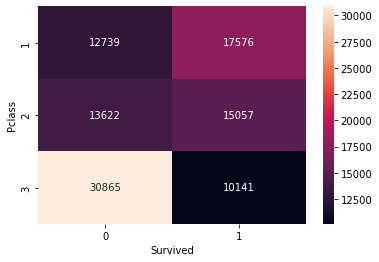

In [76]:
group = dataset.groupby(['Pclass', 'Survived'])
pclass_survived = group.size().unstack()
sns.heatmap(pclass_survived, annot = True, fmt ="d")

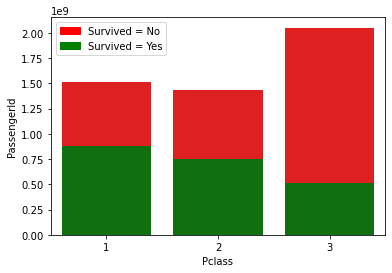

In [77]:
total = dataset.groupby('Pclass')['PassengerId'].sum().reset_index()
bar1 = sns.barplot(x='Pclass',  y='PassengerId', data=total, color='red')
survived = dataset[dataset.Survived==1]
bar2 = sns.barplot(x='Pclass',  y='PassengerId', data=survived, estimator=sum, ci=None,  color='green')
top_bar = mpatches.Patch(color='red', label='Survived = No')
bottom_bar = mpatches.Patch(color='green', label='Survived = Yes')
plt.legend(handles=[top_bar, bottom_bar])
plt.show()

Наглядно видим, что вероятность выжить была выше, при условиию, что пассажир пребывал в более состоятельном классе,
причём разница в проценте выживших между средним и высоким классом была незначительна, в то время как низкий класс представлял значительное различие, то есть вероятность выжить в низком классе была значительно больше, чем в среднем или в высоком.

Проверим, как пол влияет на выживаемость пассажира:

<AxesSubplot:xlabel='Sex'>

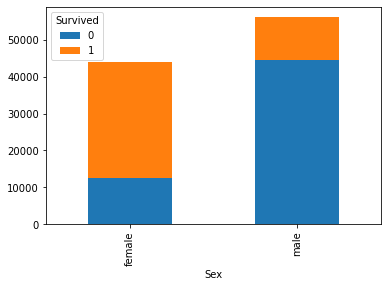

In [78]:
dataset.pivot_table('PassengerId', 'Sex', 'Survived', 'count').plot(kind='bar', stacked=True)
#sns.catplot(x ="Sex", hue ="Survived",
#kind ="count", data = dataset)

Заметим, что выживаемость у пассажиров женского пола значительно выше, чем у мужского.

Сделаем более детальный анализ, добавив в наш график переменную Age:

<AxesSubplot:xlabel='Sex', ylabel='Age'>

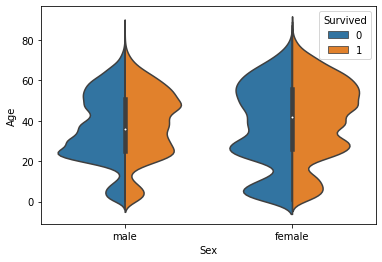

In [79]:
sns.violinplot(x ="Sex", y ="Age", hue ="Survived",
data = dataset, split = True)

Отметим несколько фактов:

1.С повышением возраста у мужчины увеличивались шансы выжить

2.Среди детей выжило примерно около половины, причём детей женского пола погибло больше

3.Высокий шанс выживания был у женщин в возрасте 25-70 лет


Теперь проанализируем как количество родственников влияло на выживание пассажира:

C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Lenovo\anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


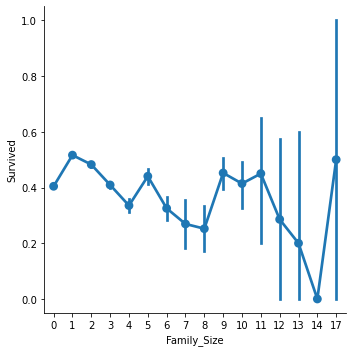

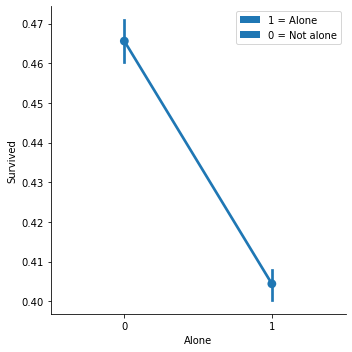

In [80]:
dataset['Family_Size'] = 0
dataset['Family_Size'] = dataset['Parch']+dataset['SibSp']

dataset['Alone'] = 0
dataset.loc[dataset.Family_Size == 0, 'Alone'] = 1

sns.factorplot(x ='Family_Size', y ='Survived', data = dataset)
 
sns.factorplot(x ='Alone', y ='Survived', data = dataset)
top_bar = mpatches.Patch(label='1 = Alone')
bottom_bar = mpatches.Patch(label='0 = Not alone')
plt.legend(handles=[top_bar, bottom_bar])
plt.show()

На первом графике отметим, что количество родственников в значении 6-8 родственников незначительно уменьшало шансы
пассажира выжить, в то время как в значениях от 11 и больше, шансы пассажира выжить значительно уменьшались (учтём, что
пассажиров с 17 родственников было всего двое, поэтому значение 17 можно считать выбросом, ввиду недостаточного количества
пассажиров, для корректного отображения вероятности)
На втором графике отчётливо видно, что одинокие пассажиры имели гораздо  меньше шансов выжить, чем пассажиры с
родственниками.

<AxesSubplot:>

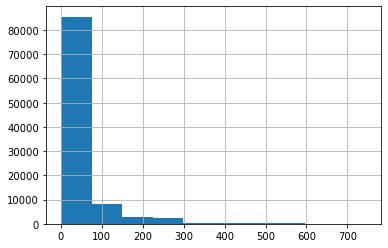

In [81]:
dataset.Fare.hist()
#описать

In [82]:
dataset.Cabin.isna().sum() / 100000
# проанализировать зависимость выживания от известности номера кабины

0.67866

In [83]:
temp_df = dataset.pivot_table('PassengerId', ['SibSp'], 'Survived', 'count')
temp_df
# посмотреть для женщин и мужчин отдельно

Survived,0,1
SibSp,,
0,42017,31291
1,11188,8570
2,2022,1681
3,981,654
4,729,439
5,107,25
8,182,114


<AxesSubplot:title={'center':'Parch'}, xlabel='Parch'>

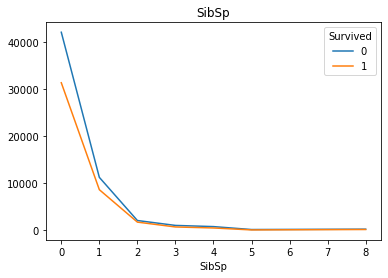

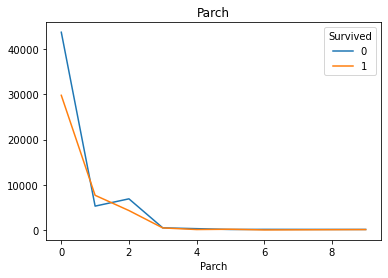

In [84]:
dataset.pivot_table('PassengerId', ['SibSp'], 'Survived', 'count').plot(title='SibSp')
dataset.pivot_table('PassengerId', ['Parch'], 'Survived', 'count').plot(title='Parch')

In [85]:
#процент выживших
dataset[dataset.Survived == 1].Survived.count() / dataset.Survived.count()

0.42774

Заметим странную, но интересную закономерность, что значительная часть пассажиров, находящихся в одинаковых каютах
в своём большинстве оплачивали цену за билет, существенно отличающуюся  между собой.

In [86]:
#df = dataset.dropna(axis='index', how='any')
fare_of_cabin = dataset.groupby('Cabin').agg({'Fare':'std'}).dropna().sort_values(by=['Fare'], ascending=False)
fare_of_cabin[fare_of_cabin.Fare > 40].Fare.count() / fare_of_cabin.Fare.count()

0.5114813147230977

Посмотрим на наличие возможных статистических связей между признаками объектов используя матрицу корреляций. Можно сделать предварительные выводы, которые подтверждают мысли высказанные ранее. В частности, что шансы выжить уменьшаются с ростом класса и возраст — очень слабый признак для построения модели. Также можно обнаружить и другие закономерности. Между возрастом и классом существует отрицательная корреляция, что, скорее всего, связано с более возрастные пассажиры чаще могли себе позволить более дорогую каюту. Кроме того, стоимость билета и класс тесно связаны (значительный коэффициент корреляции), что вполне ожидаемо.

In [87]:
dataset = pd.read_csv('for_eda.csv')

<AxesSubplot:>

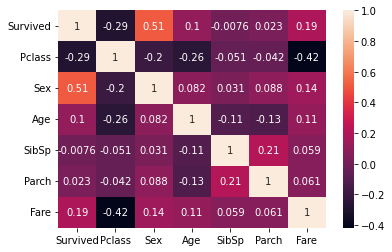

In [88]:
dataset.loc[dataset.Sex == 'male', 'Sex'], dataset.loc[dataset.Sex == 'female', 'Sex'] = 0, 1
df = dataset.drop(['PassengerId', 'Cabin', 'Name', 'Ticket', 'Embarked'], axis=1)
df["Sex"] = pd.to_numeric(df["Sex"])
sns.heatmap(data=df.corr(), annot=True)

In [89]:
dataset[dataset.Embarked.isnull()].Embarked.shape

(250,)

In [90]:
#df['isCabin']

In [91]:
dataset.groupby('Pclass').agg({'Fare':'median'})

,Fare
Pclass,
1,63.58
2,22.72
3,10.96


In [92]:
dataset.groupby('Embarked').agg({'PassengerId':'count'})

,PassengerId
Embarked,
C,22187
Q,5424
S,72139


Заметим, что у цены билета в независимости от класса очень велико значения разброса:

In [93]:
# нужен график
#dataset.pivot_table('Fare', 'Pclass', 'Survived', 'max').plot(kind='bar', stacked=True)
print(dataset[dataset.Pclass == 3].Fare.max(), dataset[dataset.Pclass == 3].Fare.min(),
      dataset[dataset.Pclass == 2].Fare.max(), dataset[dataset.Pclass == 2].Fare.min(),
     dataset[dataset.Pclass == 1].Fare.max(), dataset[dataset.Pclass == 1].Fare.min())

640.79 0.68 613.43 1.72 744.66 3.38


На основе этого можно сделать вывод, что цена билета значительно затрудняет определение пассажира к какому-то определённому
классу.

In [ ]:
Проверим, влияет ли длина имени на выживаемость (возможно длинные имена и двойные фамилии были только у аристократичных
пассажиров):

<AxesSubplot:xlabel='Survived', ylabel='len_of_name'>

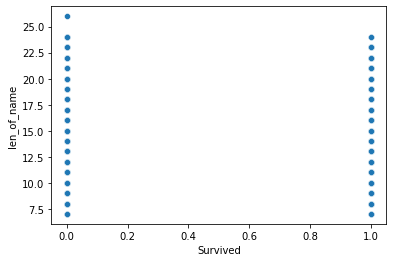

In [120]:
#df = dataset[['']]
dataset['len_of_name'] = dataset.Name.apply(len)
#dataset.sort_values(by=['len_of_name'], ascending=False).
sns.scatterplot(x=dataset.Survived, y=dataset.len_of_name)


Как видим, длина имени не даёт значительных различий для классификации выживших.

In [ ]:
Проверим гипотезу о том, что люди, каюты которых известы, скорее всего выжили:

In [108]:
dataset.loc[dataset.Cabin.isna() , 'Cabin'] = 0
dataset.loc[dataset.Cabin != 0, 'Cabin'] = 1

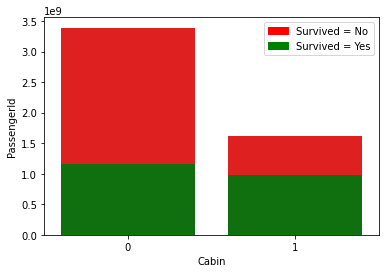

In [103]:
total = dataset.groupby('Cabin')['PassengerId'].sum().reset_index()
bar1 = sns.barplot(x='Cabin',  y='PassengerId', data=total, color='red')
survived = dataset[dataset.Survived==1]
bar2 = sns.barplot(x='Cabin',  y='PassengerId', data=survived, estimator=sum, ci=None,  color='green')
top_bar = mpatches.Patch(color='red', label='Survived = No')
bottom_bar = mpatches.Patch(color='green', label='Survived = Yes')
plt.legend(handles=[top_bar, bottom_bar])
plt.show()

Как видим, процент выживших людей, номер каюты которых известен, значительно больше, чем людей, номер каюты который узнать 
не удалось.

# Summary


Данные были обработаны:пропущенные значения заполнялись, там где это было возможно медианным значением, с разделением на класс,
там где не было возможно заполнить, оставались так, с дальнейшей возможностью удаления, либо с их дальнейшим использованием.
Большие данные датасета были проанализированны с помощью всевозможных графиков, а также корреляционной матрицыю
По итогу можно определить, что наиболее важные характеристики, определяющие вероятность пассажира выжить, оказались:
Sex, Age, Pclass, Fare, SibSp, Parch, Cabin
Остальные же признаки не дали столь существенной пользы в классификации выживших пассажиров.
После завершения EDA результирующий набор данных можно использовать для более-менее точных прогнозов.